In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression


import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [16]:
df=pd.read_csv('../data/flight_data.csv')

In [17]:
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15/01/2023,16/01/2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15/01/2023,16/01/2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"
3,15/01/2023,16/01/2023,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794"
4,15/01/2023,16/01/2023,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955"


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Date of Booking  452088 non-null  object
 1   Date of Journey  452088 non-null  object
 2   Airline-Class    452088 non-null  object
 3   Departure Time   452088 non-null  object
 4   Arrival Time     452088 non-null  object
 5   Duration         452088 non-null  object
 6   Total Stops      452088 non-null  object
 7   Price            452088 non-null  object
dtypes: object(8)
memory usage: 27.6+ MB


In [19]:
df.isnull().sum()

Date of Booking    0
Date of Journey    0
Airline-Class      0
Departure Time     0
Arrival Time       0
Duration           0
Total Stops        0
Price              0
dtype: int64

Data Cleaning


In [20]:
def clean_flight_data(df):
    
    #Airline Class
    df['Airline-Name']=df['Airline-Class'].str.split('\n').str[0].str.strip()

     
    df['Class'] = df['Airline-Class'].str.split('\n').str[-1].str.strip()
    
    #journey date
    df['Date of Journey']=pd.to_datetime(df['Date of Journey'],format='%d/%m/%Y')
    
    #date of booking 
    df['Date of Booking']=pd.to_datetime(df['Date of Booking'],format='%d/%m/%Y')
    
    #days before flight
    df['days_before_flight']=(df['Date of Journey']-df['Date of Booking']).dt.days
    
    # day of booking
    df['journey_day']=df['Date of Journey'].dt.day
    
    df['journey_day_name']=df['Date of Journey'].dt.day_name()
    
   
    
    # Departure City
    df['Departure City']=df['Departure Time'].str.split('\n').str[1].str.strip()    
    
    # Arrival City
    df['Arrival City']=df['Arrival Time'].str.split('\n').str[1].str.strip()
    
    
    #TotalStops Cleanup
    df['Total Stops'] = df['Total Stops'].str.replace(r'\n\s*\t*', '', regex=True)
    df['Total Stops'] = df['Total Stops'].str.replace(r'(stop).*', r'\1', regex=True)
    
    #Departure Time
    df['Departure_Time']=df['Departure Time'].str.split('\n').str[0].str.strip()
    
    #Arrival Time
    df['Arrival_Time']=df['Arrival Time'].str.split('\n').str[0].str.strip()
    
    #Duration
    df['Duration'] = df['Duration'].str.extract(r'(\d+)h (\d+)m') \
                                     .astype(float) \
                                     .apply(lambda x: round(x[0] + x[1] / 60, 4), axis=1)
    # Extract hour from 'arrival' column
    df['arrival_time'] = pd.to_datetime(df['Arrival_Time'], format='%H:%M').dt.hour

    # Categorize arrivals based on the hour
    df['arrival_category'] = df['arrival_time'].apply(lambda x: 'Before 7pm' if x < 19 else 'After 7pm')
                            
    #drop columns
    df.drop(['Date of Booking','Date of Journey','Airline-Class','Departure Time','Arrival Time','arrival_time'],axis=1,inplace=True)
                            
    df['Price'] = df['Price'].replace(',', '', regex=True).astype(int)
    return df

In [21]:
df = clean_flight_data(df)


In [22]:
df.sample(4)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,Departure City,Arrival City,Departure_Time,Arrival_Time,arrival_category
102313,13.8333,1-stop,54608,Air India,BUSINESS,9,24,Tuesday,Mumbai,Bangalore,21:05,10:55,Before 7pm
449258,24.7500,1-stop,54388,Vistara,BUSINESS,31,15,Wednesday,Ahmedabad,Chennai,15:35,16:20,Before 7pm
247311,11.0000,1-stop,39790,Vistara,BUSINESS,46,2,Thursday,Hyderabad,Delhi,21:35,08:35,Before 7pm
175798,9.4167,1-stop,5319,AirAsia,ECONOMY,35,19,Sunday,Bangalore,Delhi,05:05,14:30,Before 7pm


Feature Engineering

In [23]:
def feat_eng(df):
    #concatenate route
    df['Route'] = df['Departure City'] + ' -> ' + df['Arrival City']
    
    #drop appended columns above
    df.drop(['Departure City','Arrival City'],axis=1,inplace=True)
    
    
    ## Convert Departure and Arrival to the hr
    df['Departure_Time_hr']=pd.to_datetime(df['Departure_Time'], format='%H:%M').dt.hour
    df['Arrival_Time_hr']=pd.to_datetime(df['Arrival_Time'], format='%H:%M').dt.hour
    
    df.drop(['Departure_Time','Arrival_Time'],axis=1,inplace=True)
    
    
    
    return(df)

In [24]:
df=feat_eng(df)

In [25]:
df.sample(2)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,arrival_category,Route,Departure_Time_hr,Arrival_Time_hr
286237,16.4167,1-stop,10805,Air India,ECONOMY,42,26,Sunday,Before 7pm,Hyderabad -> Chennai,16,8
357066,28.8333,1-stop,14233,Air India,ECONOMY,28,12,Sunday,Before 7pm,Chennai -> Delhi,8,13


In [26]:
df=df[(df['Airline-Name']=='Air India') & (df['Class']=='ECONOMY')  & (df['Route']=='Delhi -> Mumbai') ]

In [27]:
df.sample(2)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,arrival_category,Route,Departure_Time_hr,Arrival_Time_hr
11360,17.5000,1-stop,15618,Air India,ECONOMY,30,14,Tuesday,After 7pm,Delhi -> Mumbai,4,22
18385,2.3333,non-stop,5955,Air India,ECONOMY,49,5,Sunday,Before 7pm,Delhi -> Mumbai,14,16


In [28]:
# drop airline name and class after filtering
df.drop(['Class','Airline-Name','Route'],inplace=True,axis=1)

Encoding

In [29]:
def enc_data(df):
    # Total Stops
    df=pd.get_dummies(df, columns=['Total Stops'], prefix='Stops',dtype=int)  
      

    
    # frequency coding journey day name
    frequency_map = df['journey_day_name'].value_counts(normalize=True).to_dict()
    df['journey_day_name_FreqEnc'] = df['journey_day_name'].map(frequency_map)
    
    df.drop(['journey_day_name'],axis=1,inplace=True)
    
    #label encoding arrival_category
    label_encoder = LabelEncoder()
    df['arrival_category'] = label_encoder.fit_transform(df['arrival_category'])
    
        
    return (df) 

In [30]:
enc_df=enc_data(df)

In [31]:
enc_df.sample(3)

,Duration,Price,days_before_flight,journey_day,arrival_category,Departure_Time_hr,Arrival_Time_hr,Stops_1-stop,Stops_non-stop,journey_day_name_FreqEnc
16112,4.8333,8160,43,27,1,13,18,1,0,0.165268
16086,9.8333,7194,43,27,0,13,23,1,0,0.165268
14276,24.1667,7704,38,22,1,9,9,1,0,0.149216


Modeling - Xgboost Regressor

In [32]:
# Predictor & target variables
X=enc_df.drop(['Price',],axis=1)
y=enc_df['Price']
    
#split the dataset for train&test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [33]:
def xgboostmodel(enc_df):
    
    
    model = xgb.XGBRegressor(learning_rate= 0.06375277732583517, 
                             max_depth= 7, 
                             subsample= 0.7753243552829342, 
                             colsample_bytree= 0.7687203075487558,
                             min_child_weight=1)
    model.fit(X_train, y_train)

    
    return model

In [34]:
model = xgboostmodel(enc_df)
model

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7687203075487558
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import

In [35]:
predicted_prices=model.predict(X_test)
predicted_prices

array([13691.624 ,  9156.202 ,  7882.9414,  8348.279 ,  6378.26  ,
        7500.695 ,  7012.5522,  7993.8755,  9193.143 , 12730.418 ,
        6076.08  ,  6718.5586,  6459.286 ,  7477.4414,  6176.4644,
        7884.209 ,  7975.7114,  7094.096 ,  5971.622 ,  9848.193 ,
        8635.829 ,  5936.4834,  5993.7134,  7425.1226,  7444.2236,
       15275.491 ,  6318.895 , 12077.482 , 15518.653 ,  6094.0396,
        8005.574 ,  9750.943 ,  9238.8955,  7482.176 , 18452.475 ,
        8399.744 ,  7028.373 ,  8691.963 , 11929.53  ,  9250.895 ,
        7530.0693,  8746.877 ,  8206.888 , 13301.193 ,  5968.005 ,
        6269.6885,  9273.266 , 11988.6   ,  7804.799 , 16249.373 ,
        6678.1587,  7963.605 ,  7793.1616,  7128.9565,  8217.718 ,
        7998.586 ,  9212.146 ,  5902.4272, 11414.622 , 12184.984 ,
       10258.62  ,  8349.52  ,  9494.894 ,  9878.987 ,  8239.743 ,
        9254.012 ,  8584.905 , 10478.84  ,  8531.577 ,  9702.044 ,
        9874.135 ,  8830.449 ,  8096.71  ,  8783.928 , 14761.2

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, predicted_prices)
rmse = np.sqrt(mse)

print("rmse is", rmse)


rmse is 1497.2695983021895


Feature Importance

In [38]:
# Get feature importance scores
feature_importance =model.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,Duration,0.210168
5,Arrival_Time_hr,0.172745
6,Stops_1-stop,0.170838
3,arrival_category,0.138626
4,Departure_Time_hr,0.129469
1,days_before_flight,0.083122
8,journey_day_name_FreqEnc,0.037926
2,journey_day,0.034975
7,Stops_non-stop,0.022132


Hyper Parameter Tuning

In [42]:
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 300,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    return rmse


In [43]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2026-02-19 10:30:55,738] A new study created in memory with name: no-name-b3235802-b6a8-4dfa-8ac2-6b5a7ca24a1e
[I 2026-02-19 10:30:55,948] Trial 0 finished with value: 1941.1703299813748 and parameters: {'learning_rate': 0.0580639057238499, 'max_depth': 7, 'subsample': 0.11485362364439793, 'colsample_bytree': 0.2466595443458668, 'min_child_weight': 12}. Best is trial 0 with value: 1941.1703299813748.
[I 2026-02-19 10:30:56,136] Trial 1 finished with value: 1671.8249011185353 and parameters: {'learning_rate': 0.0865300248030762, 'max_depth': 6, 'subsample': 0.17169700234681123, 'colsample_bytree': 0.3872235014498824, 'min_child_weight': 7}. Best is trial 1 with value: 1671.8249011185353.
[I 2026-02-19 10:30:56,281] Trial 2 finished with value: 1513.576311257546 and parameters: {'learning_rate': 0.04674385350815729, 'max_depth': 5, 'subsample': 0.9665532205169439, 'colsample_bytree': 0.9080106687655148, 'min_child_weight': 1}. Best is trial 2 with value: 1513.576311257546.
[I 2026-02-

In [44]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.061867509493901796, 'max_depth': 8, 'subsample': 0.9940244322971874, 'colsample_bytree': 0.6689669310808475, 'min_child_weight': 9}
Best RMSE: 1382.8245550321992


In [45]:
import numpy as np
from scipy.optimize import minimize

# Calculate revenue before optimization
revenue_before = np.sum(predicted_prices)

# Define the objective function (maximize revenue)
def objective_function(prices):
    revenue = -np.sum(prices)  
    return revenue

# Define constraints
def constraint(prices, predicted_prices, min_revenue):
    return np.concatenate([prices - predicted_prices, predicted_prices * 1.2 - prices, [np.sum(prices) - min_revenue]])

# Define initial prices (use predicted prices as initial guess)
initial_prices = predicted_prices

# Minimum revenue constraint
min_revenue = np.sum(predicted_prices) * 0.9  



# Adjust constraints to ensure prices are no lower than predicted and no greater than 1.2 times predicted
bounds = [(price, price * 1.2) for price in predicted_prices]

# Perform optimization
result = minimize(objective_function, initial_prices, constraints={'type': 'ineq', 'fun': constraint, 'args': (predicted_prices, min_revenue)}, bounds=bounds)

# Get optimized prices
optimized_prices = result.x

# Calculate revenue after optimization
revenue_after = np.sum(optimized_prices)

# Print revenue before and after optimization
print("Revenue before optimization:", revenue_before)
print("Revenue after optimization:", revenue_after)

Revenue before optimization: 5.1848695e+06
Revenue after optimization: 6221193.075685666


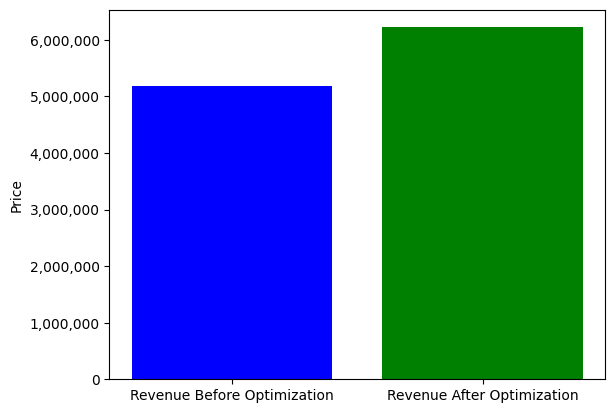

In [46]:
# Define revenue before and after optimization
revenue_values = [revenue_before, revenue_after]

# Define labels for the bars
labels = ['Revenue Before Optimization', 'Revenue After Optimization']


# Plotting
plt.bar(labels, revenue_values, color=['blue', 'green'])
plt.ylabel('Price')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [47]:
prices_df = pd.DataFrame({
    'Predicted Prices': predicted_prices,
    'Optimized Prices': optimized_prices
})
prices_df

,Predicted Prices,Optimized Prices
0,13691.624023,16429.949219
1,9156.202148,10987.443359
2,7882.941406,9459.530273
3,8348.279297,10017.935547
4,6378.259766,7653.912109
5,7500.694824,9000.833984
6,7012.552246,8415.063477
7,7993.875488,9592.651367
8,9193.142578,11031.771484
9,12730.417969,15276.501953


Text(0.5, 1.0, 'Distribution of Predicted and Optimized Prices')

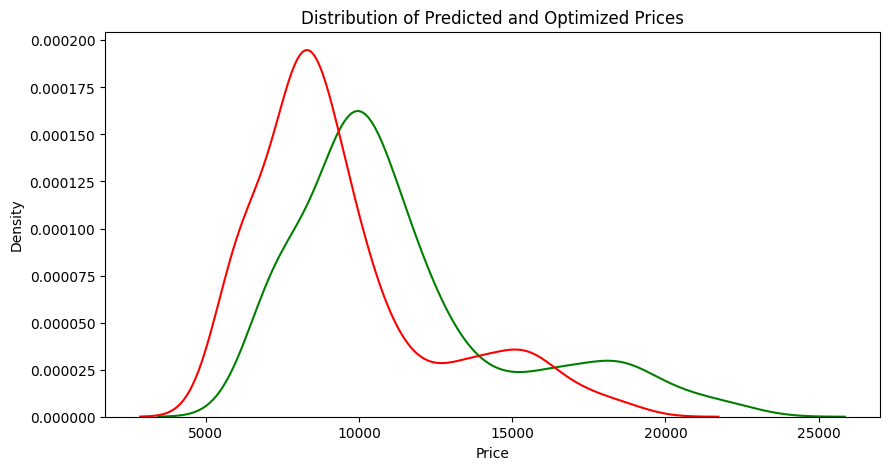

In [48]:
from matplotlib.pyplot import figure

#set size
figure(figsize=(10,5))
       
sns.kdeplot(x=optimized_prices, label='Optimized Prices',color='green')
sns.kdeplot(x=predicted_prices, label='Predicted Prices',color='red')

plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Predicted and Optimized Prices')